# Part I - IN THEORY

## Problem 1. Discriminant Functions

In order to find and plot the discrimant functions for the Gaussians, we should first define a general discrimant function that computes the decision boundary given Gaussian statistics. We can then generate the boundaries by feeding necessary parameters. For this problem, we assume that the number of samples in each class is the same. That is, $N_{1}=N_{2}$, where $N_{i}$ represents the number of samples in class $i$. With this assumption, we can easily conclude that $logP(\omega_{1})=logP(\omega_{2})$, where $P(\omega_{i})$ is the probabiliy of class $\omega_{i}$. This will become useful when we compute the boundary function because the $P(\omega_{i})$ term can be canceled on both sides.

In [1]:
import matplotlib
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from numpy import linalg as LA
from math import pi

In [2]:
class Gaussian_pairs(object):
    def __init__(self, mean1, cov1, mean2, cov2):
        self.means = [mean1, mean2]
        self.covs = [cov1, cov2]
        self.dim1 = [mean[0] for mean in [mean1, mean2]]
        self.dim2 = [mean[1] for mean in [mean1, mean2]]
    
    def find_coord(self):
        delta = 0.5
        x_min = min(self.dim1) - 5.0
        x_max = max(self.dim1) + 5.0
        y_min = min(self.dim2) - 5.0
        y_max = max(self.dim2) + 5.0
        x = np.arange(x_min, x_max, delta)
        y = np.arange(y_min, y_max, delta)
        self.X, self.Y = np.meshgrid(x, y)
        X_flat = self.X.flatten()
        Y_flat = self.Y.flatten()
        self.coord = np.stack((X_flat, Y_flat))

    def find_GDF(self):
        x_num = self.coord.shape[1]
        self.gdf = []
        for i in range(2):
            mean = self.means[i]
            cov = self.covs[i]
            w_mat = -1/2 * LA.inv(cov) # weight matrix
            w_vec = LA.inv(cov) @ mean # weight vector
            w_sca = -1/2 * mean.T @ LA.inv(cov) @ mean - 1/2 * np.log(LA.det(cov))
            gdf = np.diag(self.coord.T @ w_mat @ self.coord) + w_vec.T @ self.coord + w_sca * np.ones(x_num)
            self.gdf.append(gdf.reshape(self.X.shape))
    
    def plot_contour(self):
        plt.figure(figsize=(10,10))
        plt.contour(self.X, self.Y, self.gdf[0], levels=[-1.5,-1,-0.5], colors='red')
        plt.contour(self.X, self.Y, self.gdf[1], levels=[-1.5,-1,-0.5], colors='blue')
        plt.show()

In [3]:
means1 = np.array([[0,0],[0,0],[0,0],[0,0]])
covs1 = np.array([[[1,0],[0,1]],[[1,0],[0,2]],[[1,0],[0,2]],[[1,0],[0,2]]])
means2 = np.array([[4,0],[4,3],[1/2,0],[4,0]])
covs2 = np.array([[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[2,1]]])

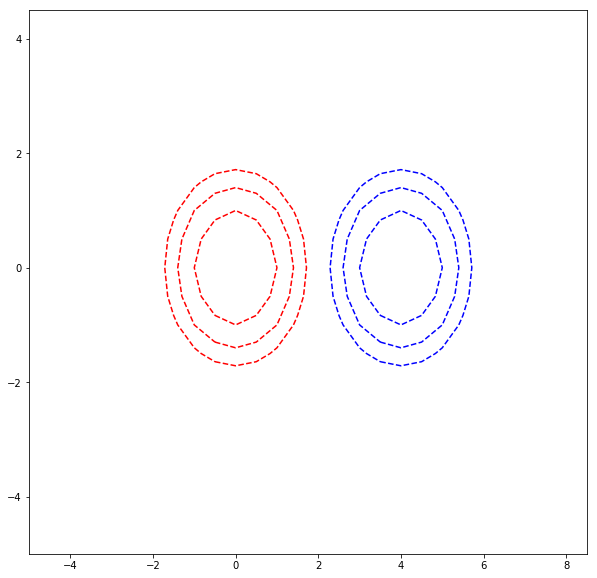

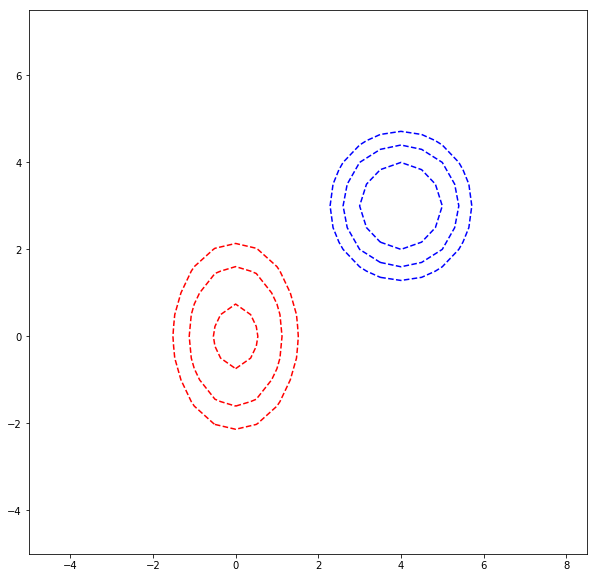

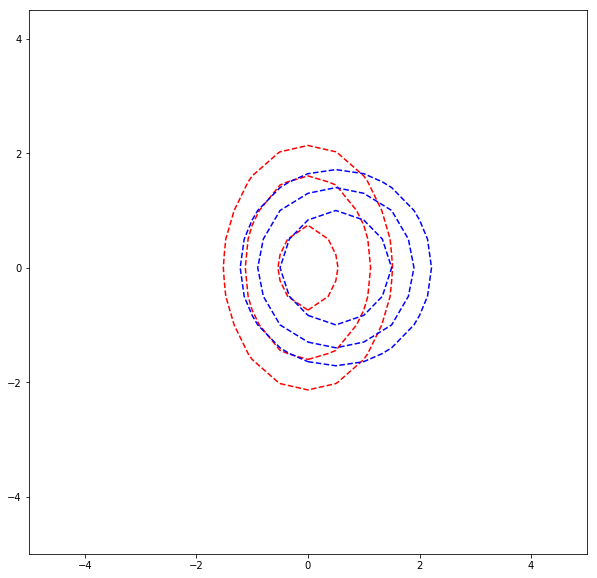

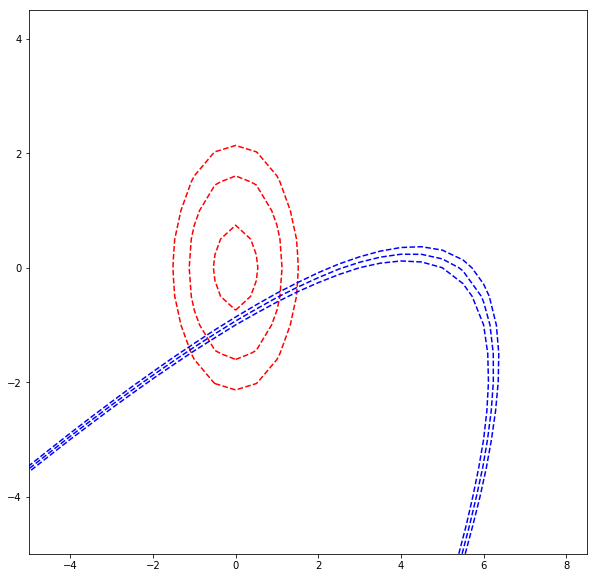

In [4]:
GP = []
for i in range(4):
    GP.append(Gaussian_pairs(means1[i], covs1[i], means2[i], covs2[i]))
    GP[i].find_coord()
    GP[i].find_GDF()
    GP[i].plot_contour()

# Part II - IN PRACTICE
## Problem 2. Handwritten Digit Recognition

In [5]:
datafile = np.load('digits-labels.npz')
d_data = datafile['d'].T
d_label = datafile['l']

In [6]:
d_train_data = np.zeros((1000,784))
d_train_label = []
d_test_data = []
d_test_label = []
for c in range(10):
    d_train_data[(c*100):(c*100)+100] = d_data[np.where(d_label==c)[0][:100]]
    d_train_label.append(d_label[np.where(d_label==c)[0][:100]])
    d_test_data = np.append(d_test_data, d_data[np.where(d_label==c)[0][100:]])
    d_test_label.append(d_label[np.where(d_label==c)[0][100:]])
d_test_data = d_test_data.reshape((-1, 784))

In [7]:
def pca(x, k):
    from scipy.sparse.linalg import eigsh
    xm = x - np.mean( x, axis=1, keepdims=True)
    C = xm.dot( xm.T) / (xm.shape[1]-1)
    v,u = eigsh( C, k=k)
    w = np.diag( 1./np.sqrt(v)) @ u.T
    y = w @ xm
    return y,w
def MN(x, mu, sigma):
    k = x.shape[1]
    x_norm = x-mu
    return 1/np.sqrt((2*pi)**k * LA.det(sigma)) * np.exp(-0.5 * np.diag(x_norm @ LA.inv(sigma) @ x_norm.T))

In [8]:
class Gaussian_clusters(object):
    def __init__(self, x, y, k, cluster):
        self.x = x
        self.y = y
        self.k = k
        self.cluster = cluster
        self.x_mean = np.mean(x, axis=0)
        
    def find_clusters(self):
        self.means = np.zeros((self.cluster, self.k))
        self.covs = np.zeros((self.cluster, self.k, self.k))
        temp_pca, self.w_pca = pca(self.x.T, self.k)
        temp_pca = temp_pca.T
        z_pca = []
        offset = 0
        for c,y in enumerate(self.y):
            y_num = len(y)
            z_pca.append(temp_pca[offset:offset+y_num])
            self.means[c] = np.mean(z_pca[c], axis=0)
            self.covs[c] = np.cov(z_pca[c].T)
            offset += y_num
        
    def predict(self, test_x, test_y):
        test_pca = self.w_pca @ (test_x - self.x_mean).T
        test_pca = test_pca.T
        prob_mat = np.zeros((self.cluster, len(test_pca)))
        for c in range(self.cluster):
            prob_mat[c] = MN(test_pca, self.means[c], self.covs[c])
        pred = np.argmax(prob_mat, axis=0)
        confusion_mat = np.zeros((self.cluster, self.cluster))
        offset = 0
        acc = np.zeros(self.cluster)
        for c in range(self.cluster):
            y_curr = test_y[c]
            N = len(y_curr)
            if N==0:
                continue
            y_pred = pred[offset:offset+N]
            err = len(np.where(y_curr!=y_pred)[0])
            acc[c] = (N-err)/N
            for i in range(self.cluster):
                confusion_mat[c, i] = len(np.where(y_pred==i)[0])
            offset += N
        return acc, confusion_mat

In [9]:
D_GC = Gaussian_clusters(d_train_data, d_train_label, k=17, cluster=10)
D_GC.find_clusters()
d_acc, d_confusion_mat = D_GC.predict(d_test_data, d_test_label)

In [10]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#              rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

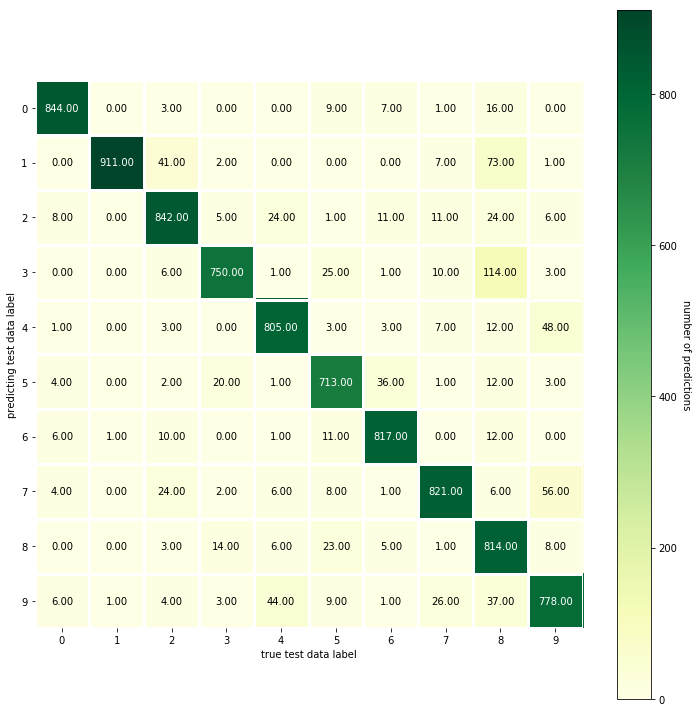

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
true_label = pred_label = [str(i) for i in range(10)]

im, cbar = heatmap(d_confusion_mat, true_label, pred_label, ax=ax,
                   cmap="YlGn", cbarlabel="number of predictions")
texts = annotate_heatmap(im)

fig.tight_layout()
plt.xlabel('true test data label')
plt.ylabel('predicting test data label')
plt.show()

## Problem 3 Speech / No Speech classifier

In [12]:
import os
from scipy.io.wavfile import read
from scipy import signal

In [13]:
window = 'hamming'
nperseg = 441
noverlap = 0

In [14]:
sm_paths = ['SpeechMusic/speech', 'SpeechMusic/music']
sm_data = [[],[]]
for p,d in zip(sm_paths, sm_data):
    for f in os.listdir(p):
        abs_f = os.path.join(p, f)
        fs, wav = read(abs_f)
        _, _, X = signal.stft(x=wav, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
        X = np.log(np.abs(X)+1e-6)
        d.append(X)

In [15]:
s_train_perc = int(len(sm_data[0]) * 0.9)
m_train_perc = int(len(sm_data[1]) * 0.9)
temp_data = [sm_data[0][:s_train_perc], sm_data[1][:m_train_perc]]
sm_train_data = [[],[]]
sm_train_label = [[],[]]
for i, ds in enumerate(temp_data):
    for d in ds:
        if len(sm_train_data[i])==0:
            sm_train_data[i] = d
        else:
            sm_train_data[i] = np.concatenate((sm_train_data[i], d), axis=1)
    sm_train_label[i] = i*np.ones(sm_train_data[i].shape[1])
sm_train_data = np.concatenate((sm_train_data[0], sm_train_data[1]), axis=1)
sm_test_data = [sm_data[0][s_train_perc:], sm_data[1][m_train_perc:]]

In [16]:
SM_GC = Gaussian_clusters(sm_train_data.T, sm_train_label, k=30, cluster=2)
SM_GC.find_clusters()
sm_acc = [0,0]
sm_confusion_mat = np.zeros((2,2))
for i, tds in enumerate(sm_test_data):
    for t in tds:
        if i==0:
            t_label = [i * np.ones(t.shape[0]),[]]
        else:
            t_label = [[], i * np.ones(t.shape[0])]
        t_acc, _ = SM_GC.predict(t.T, t_label)
        if t_acc[i] > 0.5:
            sm_acc[i] += 1
            sm_confusion_mat[i,i] += 1
        else:
            sm_acc[i] -= 1
            sm_confusion_mat[i, abs(i-1)] += 1
    sm_acc[i] /= len(tds)

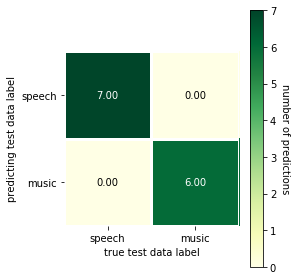

In [17]:
fig3, ax3 = plt.subplots(figsize=(4,4))
sm_true_label = sm_pred_label = ['speech', 'music']

im3, cbar3 = heatmap(sm_confusion_mat, sm_true_label, sm_pred_label, ax=ax3,
                   cmap="YlGn", cbarlabel="number of predictions")
texts3 = annotate_heatmap(im3)

fig3.tight_layout()
plt.xlabel('true test data label')
plt.ylabel('predicting test data label')
plt.show()